In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind, chi2_contingency

# Veri Seti Oluşturulması

In [41]:
# veri setinin oluşturulması

np.random.seed(42)
n = 1000

age = np.random.normal(35, 10, n)
income = np.random.normal(5000, 2000, n)
gender = np.random.choice(['Male', 'Female'], n)
marital_status = np.random.choice(['Married', 'Single', 'Divorced'], n)
education = np.random.choice(['High School', 'College', 'Graduate'], n)
missing_index = np.random.choice(range(n), size=100, replace=False) # 100 adet eksik değer oluşturacağız.
outlier_index = np.random.choice(range(n), size=50, replace=False) # 50 adet aykırı gözlem oluşturacağız.
income[outlier_index] = np.random.normal(2000, 500, size=50) # income değişkeninde aykırı gözlemleri oluşturduk.

data = pd.DataFrame({
    'Age': age, 'Income':income, 'Gender':gender,
    'Marital Status': marital_status, 'Education':education
})

data.loc[missing_index, 'Income'] = np.nan

data.head()

,Age,Income,Gender,Marital Status,Education
0,39.967142,7798.710873,Female,Divorced,College
1,33.617357,6849.267366,Male,Divorced,Graduate
2,41.476885,5119.260740,Female,Divorced,College
3,50.230299,NaN,Male,Single,Graduate
4,32.658466,NaN,Male,Single,College


# Veri Seti Analizi

In [42]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.193321,9.792159,2.587327,28.524097,35.253006,41.479439,73.527315
Income,900.0,4986.547143,2050.953789,-880.777269,3639.307372,4970.237880,6329.991941,11386.215136


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1000 non-null   float64
 1   Income          900 non-null    float64
 2   Gender          1000 non-null   object 
 3   Marital Status  1000 non-null   object 
 4   Education       1000 non-null   object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


In [44]:
data.isnull().sum()

Age                 0
Income            100
Gender              0
Marital Status      0
Education           0
dtype: int64

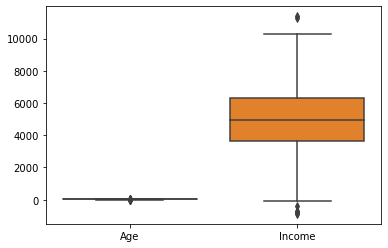

In [45]:
sns.boxplot(data=data);

# Veri Ön İşleme

In [72]:
# kategorik değişkenleri sayısal değişkenlere dönüştürelim.

lbe = LabelEncoder()
data['Gender'] = lbe.fit_transform(data['Gender']) # 0:kadın, 1:erkek
data['Marital Status'] = lbe.fit_transform(data['Marital Status']) # 0:boşanmış, 1:evli, 2:bekar
data['Education'] = lbe.fit_transform(data['Education']) # 0:College 1:Graduate 2:High School

In [47]:
# eksik gözlemleri ortalama ile dolduralım.

imputer = SimpleImputer(strategy='mean')
data['Income'] = imputer.fit_transform(data[['Income']])

In [48]:
# aykırı gözlemleri işleyelim.

q1, q3 = np.percentile(data['Income'], [25, 75])
iqr = q3 - q1
alt_sinir = q1 - 1.5 * iqr
ust_sinir = q3 + 1.5 * iqr
data = data[(data['Income'] >= alt_sinir) & (data['Income'] <= ust_sinir)]

# Veri Setinin Görselleştirilmesi

In [49]:
data.head()

,Age,Income,Gender,Marital Status,Education
0,39.967142,7798.710873,0,0,0
1,33.617357,6849.267366,1,0,1
2,41.476885,5119.260740,0,0,0
3,50.230299,4986.547143,1,2,1
4,32.658466,4986.547143,1,2,0


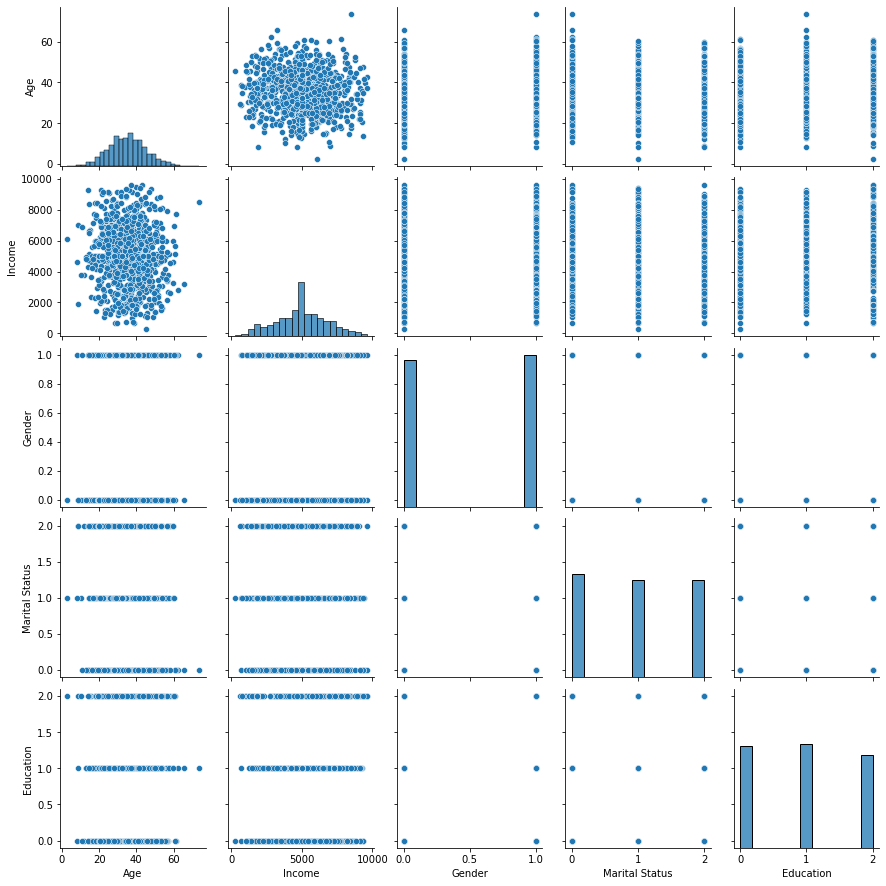

In [50]:
sns.pairplot(data=data);

# Hipotez Testleri

### H0: Erkeklerin gelirleri ile kadınların gelirleri arasında anlamlı bir fark vardır.
### H1: Erkeklerin gelirleri ile kadınların gelirleri arasında anlamlı bir fark yoktur.

In [51]:
male_income = data[data['Gender'] == 0]['Income']
female_income = data[data['Gender'] == 1]['Income']
t_stat, p_value = ttest_ind(male_income, female_income)

print('Cinsiyet ve Gelirler İlişkisi T-Testi Sonucu')
print('T-Statistic: ', t_stat)
print('P-Value: ', p_value)

Cinsiyet ve Gelirler İlişkisi T-Testi Sonucu
T-Statistic:  -0.7689609345496283
P-Value:  0.442101401388187


#### P-value değerimiz alfa değerinden (0.05) 'den büyük olduğu için hipotezimizi reddedemeyiz. Yani, erkeklerin gelirleri ile kadınların gelirleri arasında anlamlı bir fark vardır.

### H0: Evli, bekar ve boşanmış kişilerin gelirleri arasında anlamlı bir fark vardır.
### H1: Evli, bekar ve boşanmış kişilerin gelirleri arasında anlamlı bir fark yoktur.

In [52]:
married_income = data[data['Marital Status'] == 1]['Income'] 
single_income = data[data['Marital Status'] == 2]['Income']
divorced_income = data[data['Marital Status'] == 0]['Income']

f_stat, p_value, dof, expected = chi2_contingency(pd.crosstab(data['Marital Status'], pd.cut(data['Income'], 5)))

print('Medeni Durum ve Gelirler İlişkisi Chi-Square Testi Sonucu ')
print('F-Statistic: ', f_stat)
print('P-Value: ', p_value)

Medeni Durum ve Gelirler İlişkisi Chi-Square Testi Sonucu 
F-Statistic:  5.281274400466286
P-Value:  0.7271335054325873


#### P-value değerimiz alfa değerinden (0.05) büyük olduğu için hipotezimizi reddedemeyiz. Yani, evli, bekar ve boşanmış kişilerin gelirleri arasında anlamlı bir fark vardır.

# Model İşlemleri

In [53]:
# bağımsız ve bağımlı değişkenleri oluşturalım.
X = data.drop('Income', axis=1)
y = data['Income']

In [54]:
# eğitim ve test setlerinin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Model Oluşturulması
models = {
    'Linear Regression':LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
         }

In [56]:
# Model Oluşturulması, Değerlendirilmesi ve Seçimi

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{name} Modeli İçin;')
    print(f'MSE Değeri: ', mse)
    print(f'R-Kare Değeri: ', r2)

Linear Regression Modeli İçin;
MSE Değeri:  3349428.5255218945
R-Kare Değeri:  0.007285011899772265
Lasso Modeli İçin;
MSE Değeri:  3350313.3208892997
R-Kare Değeri:  0.007022773247437275
Ridge Modeli İçin;
MSE Değeri:  3349481.727076589
R-Kare Değeri:  0.0072692438425251416
ElasticNet Modeli İçin;
MSE Değeri:  3362114.387128783
R-Kare Değeri:  0.0035251332045965755


# Model Tuning İşlemi

In [60]:
# en iyi random_state değerini bulalım.
random_states = [0, 20, 42, 60, 80, 100]

for element in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'random_state={element} için; \nR-Kare Değeri: {r2}\nMSE Değeri: {mse}')

random_state=0 için; 
R-Kare Değeri: 0.0005639989677931334
MSE Değeri: 3642404.8425890263
random_state=20 için; 
R-Kare Değeri: -0.001570977839796095
MSE Değeri: 3408098.0664948313
random_state=42 için; 
R-Kare Değeri: 0.007285011899772265
MSE Değeri: 3349428.5255218945
random_state=60 için; 
R-Kare Değeri: -0.03243691274499039
MSE Değeri: 2938136.67859938
random_state=80 için; 
R-Kare Değeri: -0.011406703953826813
MSE Değeri: 3001508.025528433
random_state=100 için; 
R-Kare Değeri: 0.012083770007841665
MSE Değeri: 3580959.6936618034


### En iyi random_state değeri için modelimizi tekrar oluşturalım.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [62]:
model = LinearRegression().fit(X_train, y_train)

In [63]:
y_pred = model.predict(X_test)

In [65]:
# hiperparametreleri seçelim.

param_grid = {'fit_intercept':[True, False], 'copy_X':[True, False]}
grid = GridSearchCV(model, param_grid, cv=5)
grid_model = grid.fit(X_train, y_train)
grid_pred = grid_model.predict(X_test)

print(f'En iyi parametreler: {grid_model.best_params_}')
print(f'MSE Değeri: {mean_squared_error(y_test, grid_pred)}')
print(f'R-Kare Değeri: {r2_score(y_test, grid_pred)}')

En iyi parametreler: {'copy_X': True, 'fit_intercept': True}
MSE Değeri: 3542822.0026080795
R-Kare Değeri: 0.007247453172216756


# Model Doğrulama İşlemi

In [70]:
scores = cross_val_score(grid_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f'Cross-Validation Score: {-scores}')
print(f'Cross-Validation Mean: {scores.mean()}')

Cross-Validation Score: [3285954.54320687 4461892.94923564 3486775.24515605 3096316.87513897
 3127941.47012396 3335213.2369093  3207253.07390952 2696067.18640424
 3322990.84347225 3123674.43017636]
Cross-Validation Mean: -3314407.9853733154


# Tahmin

In [71]:
data.head()

,Age,Income,Gender,Marital Status,Education
0,39.967142,7798.710873,0,0,0
1,33.617357,6849.267366,1,0,1
2,41.476885,5119.260740,0,0,0
3,50.230299,4986.547143,1,2,1
4,32.658466,4986.547143,1,2,0


In [74]:
age = int(input('Yaşınızı Giriniz: '))
gender = input('Cinsiyetinizi Giriniz (Erkek/Kadın): ')
marital_status = input('Medeni Halinizi Giriniz (Evli/Bekar/Boşanmış): ')
education = input('Eğitim Durumunuzu Giriniz (Lise/Üniversite/Mezun): ')

if gender == 'Erkek':
    gender = 1
elif gender == 'Kadın':
    gender = 0

if marital_status == 'Evli':
    marital_status = 1
elif marital_status == 'Boşanmış':
    marital_status = 0
elif marital_status == 'Bekar':
    marital_status = 2

if education == 'Lise':
    education = 0
elif education == 'Üniversite':
    education = 2
elif education == 'Mezun':
    education = 1
    
predict = model.predict([[age, gender, marital_status, education]])

print(f'Tahmini Geliriniz: {float(predict):.2f} ')

Yaşınızı Giriniz:  23
Cinsiyetinizi Giriniz (Erkek/Kadın):  Erkek
Medeni Halinizi Giriniz (Evli/Bekar/Boşanmış):  Bekar
Eğitim Durumunuzu Giriniz (Lise/Üniversite/Mezun):  Mezun


Tahmini Geliriniz: 5059.25 


C:\Users\murat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Sonuç

### Veri setini kendimiz oluşturduğumuz için, bir gerçek hayat senaryosu değildir. Model değerlendirme kısmında elde ettiğimiz P-Value değerleri modelimizin tahmin gücüne güvenebilmek için yeterli değil.